### Libraries

In [2]:
import numpy as np
import math
import random as rd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.integrate import solve_ivp
from scipy.stats import bernoulli
from scipy.stats import expon

In [3]:
 # Description of the model and what it models

## **Modèle SIR** - Formulation Déterministe

In a population of fixed size **N**, we have:

$S(t):$ Part of the population susceptible to the contamination.

$I(t):$ Part of the population that is contaminated.

$R(t):$ Part of the population that is immune to the illness.

$$
\left\{ \begin{array}{ll}
\frac {dS(t)} {dt}  = -\frac{\beta I(t) S(t)}{N},
\\
\frac {dI(t)} {dt} =  \frac{\beta I(t) S(t)}{N} - \gamma I(t),
\\
\frac {dR(t)} {dt} = \gamma I(t)
\end{array} \right.
$$

Solving the system of differential equations: 

In [47]:
# Atributing values to the parameters
beta = 5
N = 501
gamma = 1
init_values = [500, 1, 0]
sol_interval = np.linspace(0, 1000, 100)

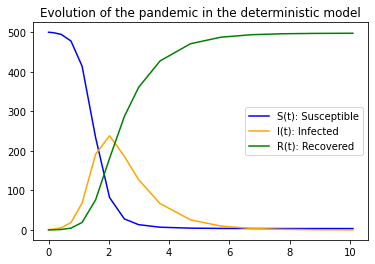

In [49]:
# Solving and plotting the system 
def f(t, y):
  return [-beta*y[1]*y[0]/N, beta*y[1]*y[0]/N - gamma*y[1], gamma*y[1]]

sol = solve_ivp(f, sol_interval, init_values)

x_axis_S = [sol.y.T[i][0] for i in range(len(sol.y.T))]
x_axis_I = [sol.y.T[i][1] for i in range(len(sol.y.T))]
x_axis_R = [sol.y.T[i][2] for i in range(len(sol.y.T))]

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(sol.t, x_axis_S, label='S(t): Susceptible', color = 'blue')
plt.plot(sol.t, x_axis_I, label='I(t): Infected', color = 'orange')
plt.plot(sol.t, x_axis_R, label='R(t): Recovered', color = 'green')
plt.legend(loc = 'best')
plt.title("Evolution of the epidemic in the deterministic model")
plt.show()

## **Modèle SIR** - Formulation Stochastique


Chaîne de Markov $(S(t), I(t), R(t), t ≥ 0)$, partant de $(S(0) = N − i_0, I(0) = i_0, R(0) = 0)$ avec probabilités de transition suivantes:

$$
\begin{array}{ll}
(S, I, R) → (S − 1, I + 1, R) & Taux_1 = \frac{\beta I S}{N}
\\
(S, I, R) → (S, I - 1, R + 1) & Taux_2 = \gamma I
\end{array}
$$

In [52]:
#Fonction de tirage aléatoire pour les transitions
def prob(taux1, taux2):

  Probab1 = taux1/(taux1+taux2)
  Probab2 = taux2/(taux1+taux2)
  
  num = rd.random()

  if num < Probab1:
    return 1
  else: return 2

In [53]:
# Fonction Epidemie
def Epidemie(N, tmax, i0, beta, gamma):

  S = np.zeros(tmax)  # Nombre de susceptibes pour chaque instant t.
  I = np.zeros(tmax)  # Nombre de infectés pour chaque instant t.
  R = np.zeros(tmax)  # Nombre de immunisés pour chaque instant t.
  T = np.zeros(tmax)  # Vector d'instants de temps.

  # Declaration of the initial state:
  S[0] = N - i0
  I[0] = i0
  R[0] = 0
  T[0] = 0

  # Propagation of the epidemic:
  for i in range(tmax-1):
    # case where there are no more infected individuals
    if I[i] == 0:
      Tfin = T[i]  # end of the epidemic
      Rfin = R[i]  # size of the epidemic
      for j in range(i+1, tmax):
        S[j] = S[i]
        I[j] = I[i]
        R[j] = R[i]
        T[j] =  Tfin
      break

    # Transition rates
    Taux1 = beta*I[i]*S[i]/N
    Taux2 = gamma*I[i]
    Sum_Taux = Taux1 + Taux2

    # Time increase with the help of exponential clocks
    increment_temps = np.random.exponential(1/Sum_Taux)
    T[i+1] = T[i] + increment_temps

    # Probability function for the transition
    Transition = prob(Taux1, Taux2)

    # Transition
    if Transition == 1:
      S[i+1] = S[i] - 1
      I[i+1] = I[i] + 1
      R[i+1] = R[i]

    if Transition == 2:
      S[i+1] = S[i]
      I[i+1] = I[i] - 1
      R[i+1] = R[i] + 1

  return [T, S, I, R, Tfin, Rfin]

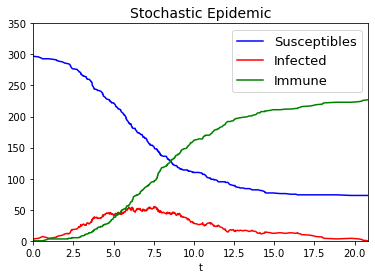

R0_critic = 1.0101010101010102
R0 = 2.0
End of the epidemic: 20.838925195287853
Size of the epidemic: 227.0


In [57]:
# Definition of the parameters 
N = 300      # size of the population
tmax = N*4   # Maximum nunber of transitions the markov chain will have
i0 = 3       # Initial number of infected individuals
beta = 1
gamma = 0.5

# Executing the Epidemic 
[T, S, I, R, Tfin, Rfin] = Epidemie(N, tmax, i0, beta, gamma)

# Plotting the curves
plt.plot(T, S, 'b', label = 'Susceptibles')
plt.plot(T, I, 'r', label = 'Infected')
plt.plot(T, R, 'g', label = 'Immune')

plt.axis([0, Tfin, 0, N+50])
plt.legend(loc="upper right", fontsize=13)
plt.xlabel("t")
plt.title("Stochastic Epidemic", fontsize=14)
plt.show()

print("R0_critic =", N/S[0])
print("R0 =", beta/gamma)
print("End of the epidemic:", Tfin)
print("Size of the epidemic:", Rfin)

### Estimation Models for $P(R(\infty) > K)$

From $K= 281$, we have the ocurrence of rare events.
Theoretical value calculated from $1,000,000$ Monte-Carlo simulations for **$K = 282$**:    $3.1$ x $10^{-5}$

#### $1$: Crude *Monte-Carlo* (**CMC**)